In [11]:
import torch
import torchvision
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
import shutil
from approx_attributes import *
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from captum.attr import InputXGradient,IntegratedGradients,Saliency
print(torch.__version__)
print(torchvision.__version__)

2.8.0+rocm6.4
0.23.0+rocm6.4


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = torch.load("resnet18_cifar10_32x32_epoch30.pth",weights_only=False)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.to(device)
model.eval()

Using cache found in /home/benomin/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
"""
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32 -> 16x16x32 (nach MaxPool)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 16x16x64 -> 8x8x64 (nach MaxPool)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*8*8, 256)  # 64*8*8 = 4096
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Input: 32x32x3
        x = F.relu(self.conv1(x))                      # -> 32x32x32
        x = F.relu(self.conv2(x))                      # -> 32x32x32
        x = F.max_pool2d(x, 2)                         # -> 16x16x32
        x = F.relu(self.conv3(x))                      # -> 16x16x64
        x = F.max_pool2d(x, 2)                         # -> 8x8x64
        x = self.flatten(x)                            # -> 4096
        x = F.relu(self.fc1(x))                        # -> 256
        x = self.fc2(x)                                # -> 10
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

if os.path.isfile("CifarModelCnn.pth"):

    state_dict = torch.load("CifarModelCnn.pth", map_location=torch.device(device))

    model.load_state_dict(state_dict)
    model.eval()
"""

'\nclass CNN(nn.Module):\n    def __init__(self):\n        super(CNN, self).__init__()\n        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32\n        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32 -> 16x16x32 (nach MaxPool)\n        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 16x16x64 -> 8x8x64 (nach MaxPool)\n        self.flatten = nn.Flatten()\n        self.fc1 = nn.Linear(64*8*8, 256)  # 64*8*8 = 4096\n        self.fc2 = nn.Linear(256, 10)\n\n    def forward(self, x):\n        # Input: 32x32x3\n        x = F.relu(self.conv1(x))                      # -> 32x32x32\n        x = F.relu(self.conv2(x))                      # -> 32x32x32\n        x = F.max_pool2d(x, 2)                         # -> 16x16x32\n        x = F.relu(self.conv3(x))                      # -> 16x16x64\n        x = F.max_pool2d(x, 2)                         # -> 8x8x64\n        x = self.flatten(x)                            # -

In [14]:
transform = transforms.Compose([transforms.ToTensor()])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

dataset = test_loader.dataset
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [15]:
def to_numpy_image(attr):
    """
    Bringt Attribution Map in Shape (H,W,C) für matplotlib.
    Erwartet Tensor oder numpy array in Form:
    - (C,H,W)
    - (H,W,C)
    - (3072,)
    - (1,C,H,W)
    """
    if isinstance(attr, torch.Tensor):
        attr = attr.detach().cpu().numpy()

    if attr.ndim == 1:  # flach: 3072
        attr = attr.reshape(3, 32, 32)

    if attr.ndim == 4:  # Batch-Format
        attr = attr.squeeze(0)  # -> (C,H,W)

    if attr.shape[0] == 3 and attr.ndim == 3:  # (C,H,W)
        attr = np.transpose(attr, (1, 2, 0))

    return attr

956
Grad Approx


/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.12/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


8832
Grad Approx
2800
Grad Approx
5859
Grad Approx
462
Grad Approx


/tmp/ipykernel_11666/3408621168.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


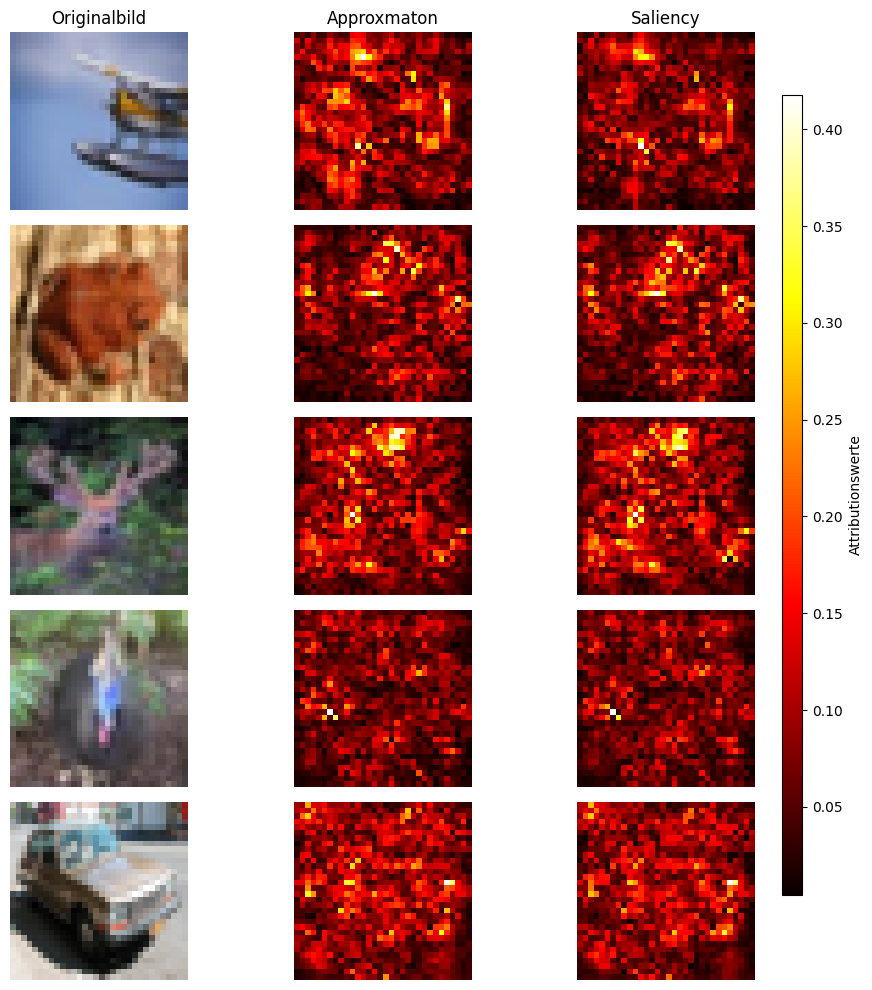

In [40]:
aa = ApproxAttribution(model)
sal = Saliency(model)
ig = IntegratedGradients(model)

idx = []
for i in range(5):
    idx.append(np.random.randint(0, len(dataset) - 1))

plt.style.use('default')

fig, axes = plt.subplots(5, 3, figsize=(10,10))
fig.set_facecolor('white')

axes[0, 0].set_title('Originalbild')
axes[0, 1].set_title('Approxmation')
axes[0, 2].set_title('Saliency')

cnt = 0
for i in idx:
    print(i)
    img, label = dataset[i]

    attribution_map = aa.grad_approx(0.1, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)

    #attribution_map = to_numpy_image(aa.grad_approx(0.1,[img.unsqueeze(0)],label))
    #attribution_map_real = to_numpy_image(sal.attribute(img.unsqueeze(0).float().to(device), target=label))

    attribution_map_real = sal.attribute(img.unsqueeze(0).float().to(device), target=label)
    attribution_map_real = attribution_map_real.squeeze().detach().cpu().numpy()  # shape: [3, 32, 32]

    attr_vis = np.abs(attribution_map).max(axis=0)
    attr_real_vis = np.abs(attribution_map_real).max(axis=0)

    image_np = img.permute(1, 2, 0).numpy()
    image_np = np.clip(image_np, 0, 1)

    im = axes[cnt,0].imshow(image_np)
    axes[cnt,0].axis('off')

    im1 = axes[cnt,1].imshow(attr_vis, cmap='hot')
    axes[cnt,1].axis('off')

    im2 = axes[cnt,2].imshow(attr_real_vis, cmap='hot')
    axes[cnt,2].axis('off')

    cnt = cnt + 1

plt.subplots_adjust(wspace=0, hspace=0.3)
cax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
#cax.axis('off')
fig.colorbar(im2, cax=cax, label='Attributionswerte', pad=0.1)
plt.tight_layout()
plt.savefig("mein_plot.png", bbox_inches='tight')
plt.show()

In [ ]:
#correlation+MSE+CosineSimilarity